# Import libs

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score, 
                            accuracy_score, precision_score, recall_score, 
                            roc_curve, precision_recall_curve, confusion_matrix, 
                            ConfusionMatrixDisplay)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
import matplotlib.colors as mcolors
from xgboost import XGBClassifier

# Data preprocessing

In [ ]:
ml_df = pd.read_csv('./data/for_ml_final_data_chromothripsis.csv', 
                    index_col=0)

In [3]:
ml_df.columns

Index(['donor_unique_id', 'Chr', 'Start_region', 'End_region', 'Intrchr_SVs',
       'Total_SVs', 'SVs_in_sample', 'Nb. DEL', 'Nb. DUP', 'Nb. h2hINV',
       'Nb. t2tINV', 'Nb. TRA', 'P fragment joints',
       'P chr breakpoint enrichment', 'TP53_mutations', 'chromo_label',
       'chromo_binary', 'SV_events'],
      dtype='object')

In [4]:
ml_df['TP53_mutations'] = ml_df['TP53_mutations'].notna().astype(int)

In [5]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19713 entries, 0 to 19712
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   donor_unique_id              19713 non-null  object 
 1   Chr                          19713 non-null  object 
 2   Start_region                 19713 non-null  float64
 3   End_region                   19713 non-null  float64
 4   Intrchr_SVs                  19713 non-null  float64
 5   Total_SVs                    19713 non-null  float64
 6   SVs_in_sample                19713 non-null  float64
 7   Nb. DEL                      19713 non-null  float64
 8   Nb. DUP                      19713 non-null  float64
 9   Nb. h2hINV                   19713 non-null  float64
 10  Nb. t2tINV                   19713 non-null  float64
 11  Nb. TRA                      19713 non-null  float64
 12  P fragment joints            19713 non-null  float64
 13  P chr breakpoint enri

In [6]:
ml_df['chromo_binary'] = (ml_df['chromo_label'] != 'No').astype(int)

In [ ]:
ml_df['chromo_binary'] = (ml_df['chromo_label'] != 'No').astype(int)

print("Распределение новых значений:")
print(ml_df['chromo_binary'].value_counts())

print("\nСоответствие между chromo_label и chromo_binary:")
print(pd.crosstab(ml_df['chromo_label'], ml_df['chromo_binary']))

Распределение новых значений:
chromo_binary
0    17461
1     2252
Name: count, dtype: int64

Соответствие между chromo_label и chromo_binary:
chromo_binary                  0    1
chromo_label                         
High confidence                0  859
Linked to high confidence      0  438
Linked to low confidence       0  292
Low confidence                 0  663
No                         17461    0


In [8]:
print("Распределение новых значений:")
print(ml_df['chromo_binary'].value_counts())

Распределение новых значений:
chromo_binary
0    17461
1     2252
Name: count, dtype: int64


In [9]:
print("\nСоответствие между chromo_label и chromo_binary:")
print(pd.crosstab(ml_df['chromo_label'], ml_df['chromo_binary']))


Соответствие между chromo_label и chromo_binary:
chromo_binary                  0    1
chromo_label                         
High confidence                0  859
Linked to high confidence      0  438
Linked to low confidence       0  292
Low confidence                 0  663
No                         17461    0


<Axes: >

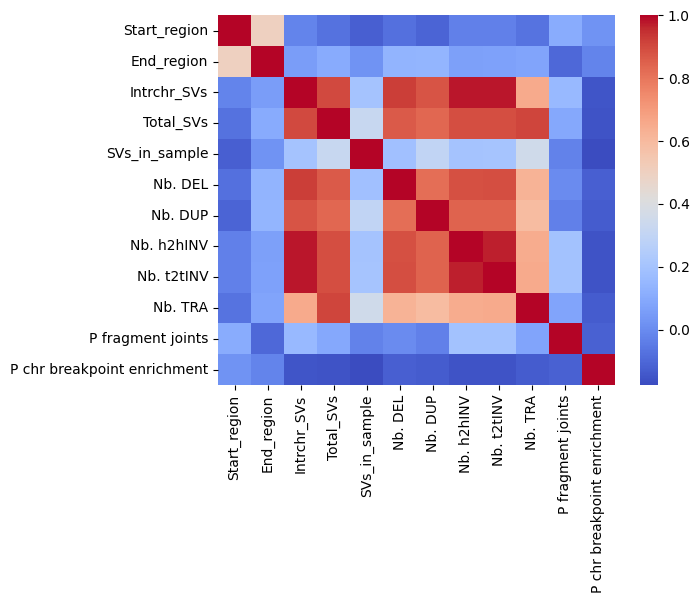

In [ ]:
for_correlation = ml_df.drop(['chromo_binary'], axis=1)
corr_matrix = for_correlation.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

In [13]:
CATEG_FEATURES = ['donor_unique_id', 'Chr', 'chromo_label', 'SV_events']
y = ml_df['chromo_binary']

In [15]:
y.mean()

0.11423933444934814

In [ ]:
cor_matrix = ml_df.drop(['chromo_binary'], axis=1).corr(numeric_only=True)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.9)]
print("Highly correlated columns to drop:", to_drop)

Highly correlated columns to drop: ['Total_SVs', 'Nb. DEL', 'Nb. h2hINV', 'Nb. t2tINV', 'Nb. TRA']


In [ ]:
ml_df_binary = ml_df.drop(['chromo_label'], axis=1)
X_encoded = ml_df_binary.drop(columns=['chromo_binary', 'donor_unique_id', 'SV_events'] + to_drop)

In [ ]:
ml_df_binary = ml_df.drop(['chromo_label'], axis=1)
X_encoded = ml_df_binary.drop(columns=['chromo_binary', 'donor_unique_id', 'SV_events'] + to_drop)

In [ ]:
chroms = pd.get_dummies(X_encoded['Chr'], prefix='Chr')
X_encoded = pd.concat([X_encoded.drop(columns=['Chr']), chroms], axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_encoded = pd.DataFrame(X_scaled, index=X_encoded.index, columns=X_encoded.columns)

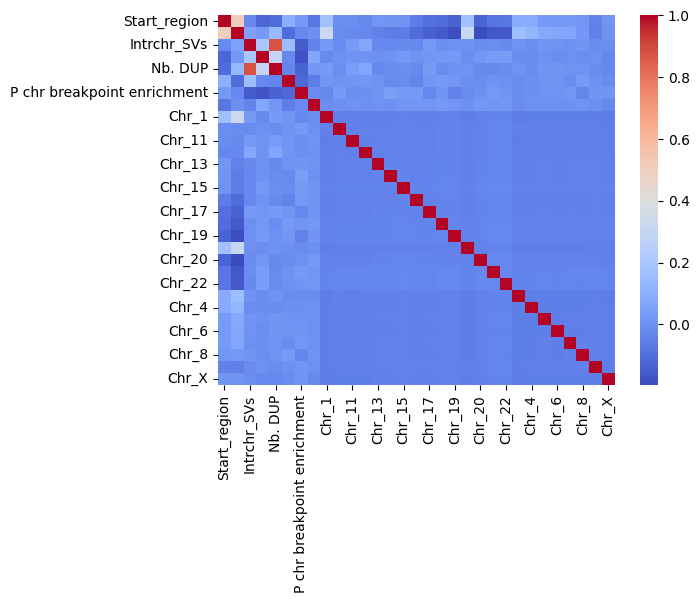

In [ ]:
sns.heatmap(X_encoded.corr(), cmap='coolwarm')
plt.show()

# Split data into train and test

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_encoded, y, train_size=0.8, random_state=42, shuffle=True, stratify=y
)

In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Model params

In [25]:
def get_models_and_params():
    scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)  # Для XGBoost
    
    models = {
        'logreg': (LogisticRegression(max_iter=1000), [
    {
        'model__class_weight': ['balanced', None],
        'model__C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
        'model__penalty': ['l2', 'l1'],
        'model__solver': ['liblinear'],
        'sampler': [SMOTE(), ADASYN(), FunctionTransformer(lambda x: x, validate=False)]
    },
    {
    'model__class_weight': ['balanced', None],
    'model__C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__solver': ['saga'],
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'sampler': [SMOTE(), ADASYN(), FunctionTransformer(lambda x: x, validate=False)]}
]),
        'rf': (RandomForestClassifier(), {
            'model__class_weight': ['balanced', 'balanced_subsample', None],
            'model__n_estimators': [200, 300, 400, 500, 600],
            'model__max_depth': [None, 3, 4, 5, 6, 7],
            'model__criterion': ['gini', 'entropy', 'log_loss'],
            'model__min_samples_split': [2, 3, 4, 5],
            'sampler': [SMOTE(), RandomUnderSampler(), FunctionTransformer(lambda x: x, validate=False)]
        }),
        'xgb': (XGBClassifier(eval_metric='logloss'), {
            'model__scale_pos_weight': [1, scale_pos_weight],
            'model__n_estimators': [200, 300, 400, 500, 600],
            'model__max_depth': [3, 4, 5, 6, 7],
            'model__learning_rate': [0.01, 0.1, 0.05],
            'model__subsample': [0.8, 0.9, 1.],
            'sampler': [SMOTE(), FunctionTransformer(lambda x: x, validate=False)]
        }),
        'svm': (SVC(probability=True), {
            'model__class_weight': ['balanced', None],
            'model__C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
            'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'sampler': [SMOTE(k_neighbors=5), BorderlineSMOTE(), FunctionTransformer(lambda x: x, validate=False)]
        })
    }
    return models

In [ ]:
def plot_metrics(y_true, y_pred, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(fpr, tpr)
    ax[0].set_title(f"ROC curve: {model_name}")
    ax[0].set_xlabel("FPR")
    ax[0].set_ylabel("TPR")
    ax[1].plot(recall, precision)
    ax[1].set_title(f"PR curve: {model_name}")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_models(X_train, y_train, X_test, y_test):
    models = get_models_and_params()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, (model, params) in models.items():
        print(f"\n=== Training {name} ===")
        pipeline = Pipeline([
            ('sampler', SMOTE()),
            ('model', model)
        ])
        grid = GridSearchCV(
            pipeline,
            param_grid=params,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1,
            error_score='raise'
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        metrics = {
            'model': name,
            'best_params': grid.best_params_,
            'roc_auc': roc_auc_score(y_test, y_proba),
            'pr_auc': average_precision_score(y_test, y_proba),
            'f1': f1_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred)
        }
        plot_metrics(y_test, y_pred, y_proba, name)
        results.append(metrics)
    return pd.DataFrame(results)

In [ ]:
def plot_metrics(y_true, y_pred, y_proba, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ax1.plot(fpr, tpr, color='#7e6bdb', lw=2, 
             label=f'{model_name} (AUC = {roc_auc_score(y_true, y_proba):.2f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=1)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc='lower right')
    
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ax2.plot(recall, precision, color='#e67f8b', lw=2,
             label=f'{model_name} (AUC = {average_precision_score(y_true, y_proba):.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [ ]:
def create_ensembles(best_models):
    voting = VotingClassifier(
        estimators=[(name, model) for name, model in best_models.items()],
        voting='soft'
    )
    
    stacking = StackingClassifier(
        estimators=[(name, model) for name, model in best_models.items()],
        final_estimator=LogisticRegression(max_iter=1000),
        cv=skf
    )
    
    return {'voting': voting, 'stacking': stacking}

In [ ]:
def plot_cv_results(models, X, y, cv):
    plt.figure(figsize=(12, 8))
    
    for name, model in models.items():
        y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
        fpr, tpr, _ = roc_curve(y, y_proba)
        roc_auc = roc_auc_score(y, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison (Cross-Validation)')
    plt.legend()
    plt.show()

In [ ]:
def compare_models(models, X_test, y_test):
    metrics = []
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        metrics.append({
            'Model': name,
            'ROC AUC': roc_auc_score(y_test, y_proba),
            'PR AUC': average_precision_score(y_test, y_proba),
            'F1': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred)
        })
        
        plot_metrics(y_test, y_pred, y_proba, name)
    
    return pd.DataFrame(metrics)

In [ ]:
def evaluate_with_ensembles(X_train, y_train, X_test, y_test):
    models = get_models_and_params()
    best_models = {}
    
    for name, (model, params) in models.items():
        print(f"\n=== Training {name} ===")
        pipeline = Pipeline([
            ('sampler', SMOTE()),
            ('model', model)
        ])
        
        grid = GridSearchCV(
            pipeline,
            param_grid=params,
            cv=skf,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
    
    ensembles = create_ensembles(best_models)
    
    for name, ensemble in ensembles.items():
        print(f"\n=== Training {name} ensemble ===")
        ensemble.fit(X_train, y_train)
        best_models[name] = ensemble
    
    plot_cv_results(best_models, X_train, y_train, skf)
    
    results = compare_models(best_models, X_test, y_test)
    
    return results

# Run training and view the results

=== Этап 1: Обучение базовых моделей ===

=== Training logreg ===
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


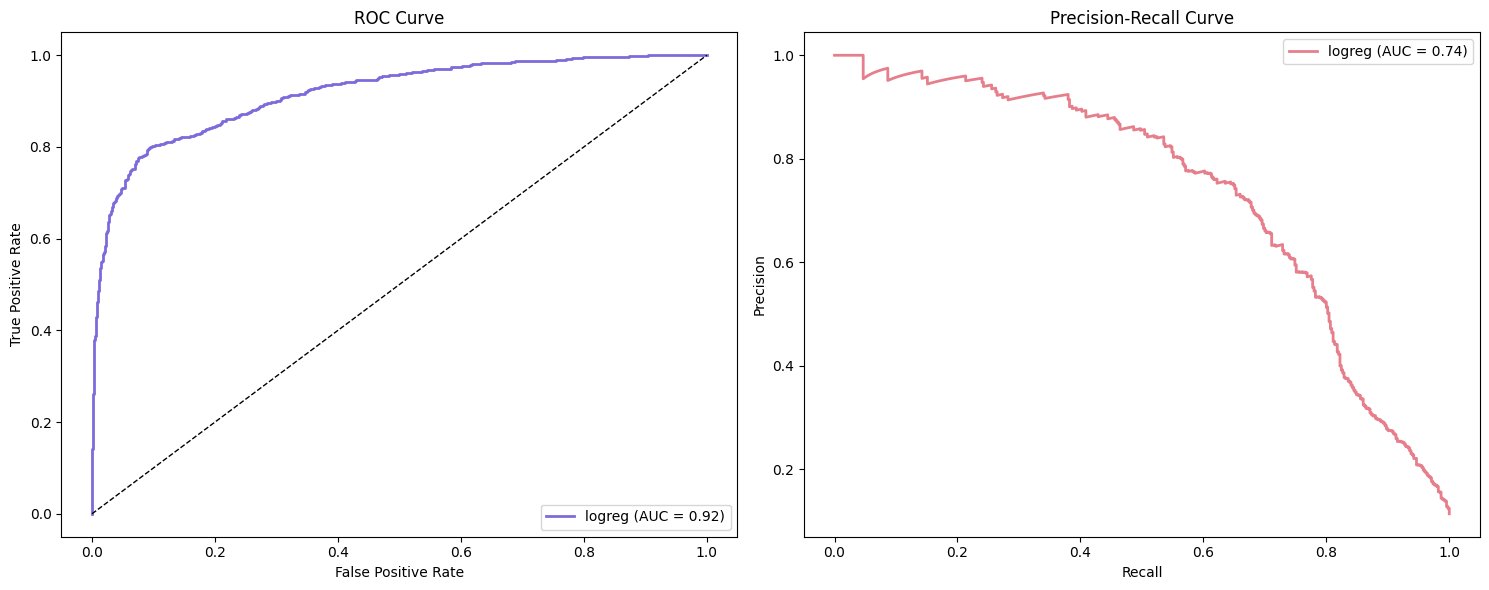

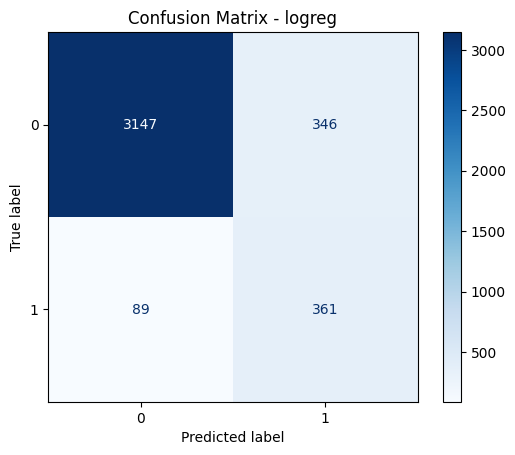


=== Training rf ===
Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


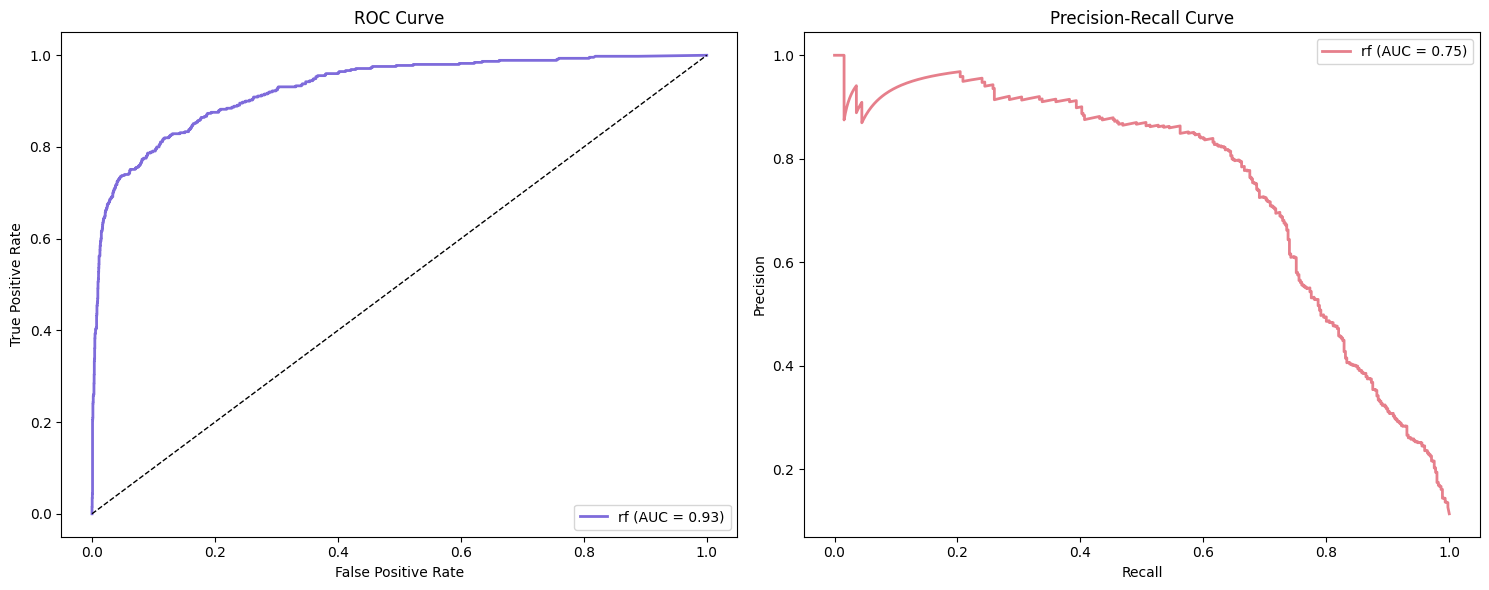

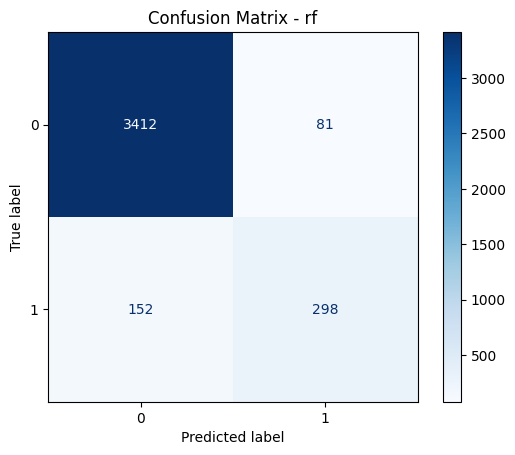


=== Training xgb ===
Fitting 5 folds for each of 900 candidates, totalling 4500 fits


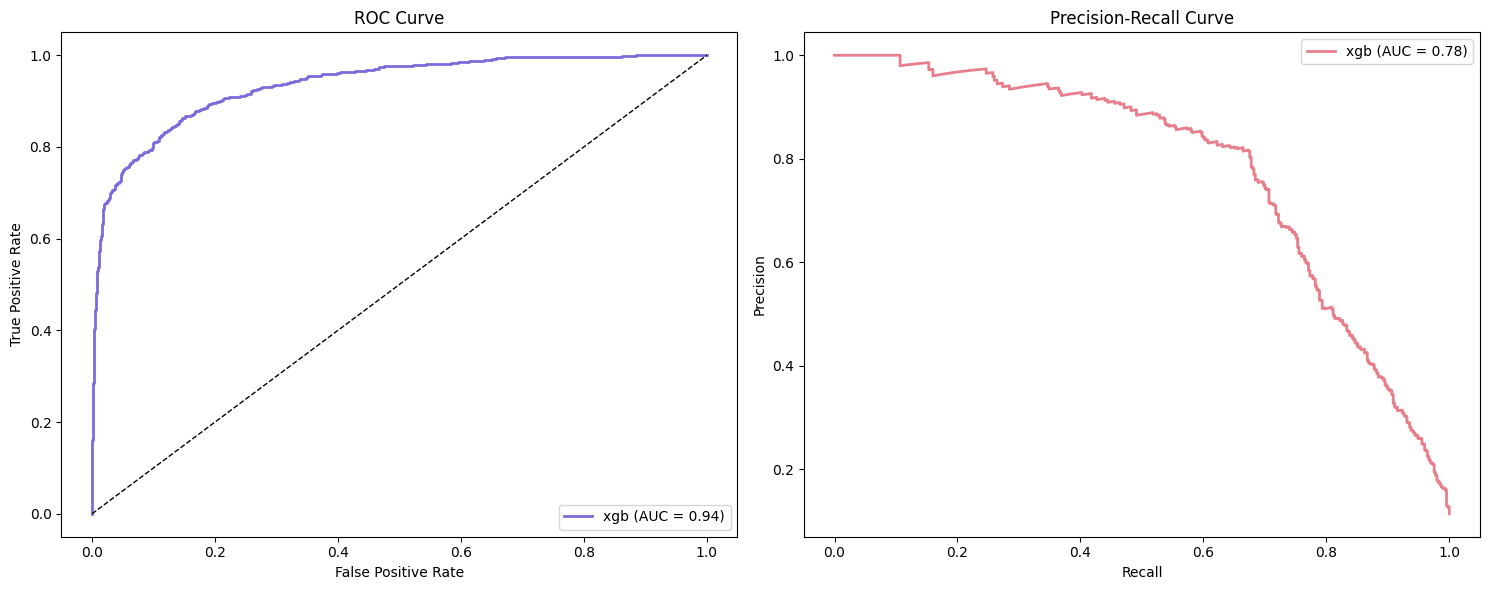

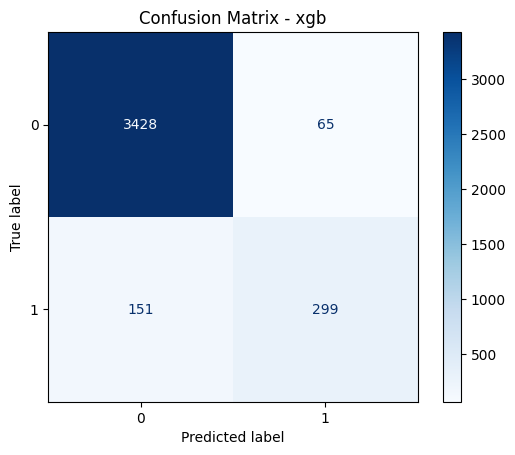


=== Training svm ===
Fitting 5 folds for each of 168 candidates, totalling 840 fits


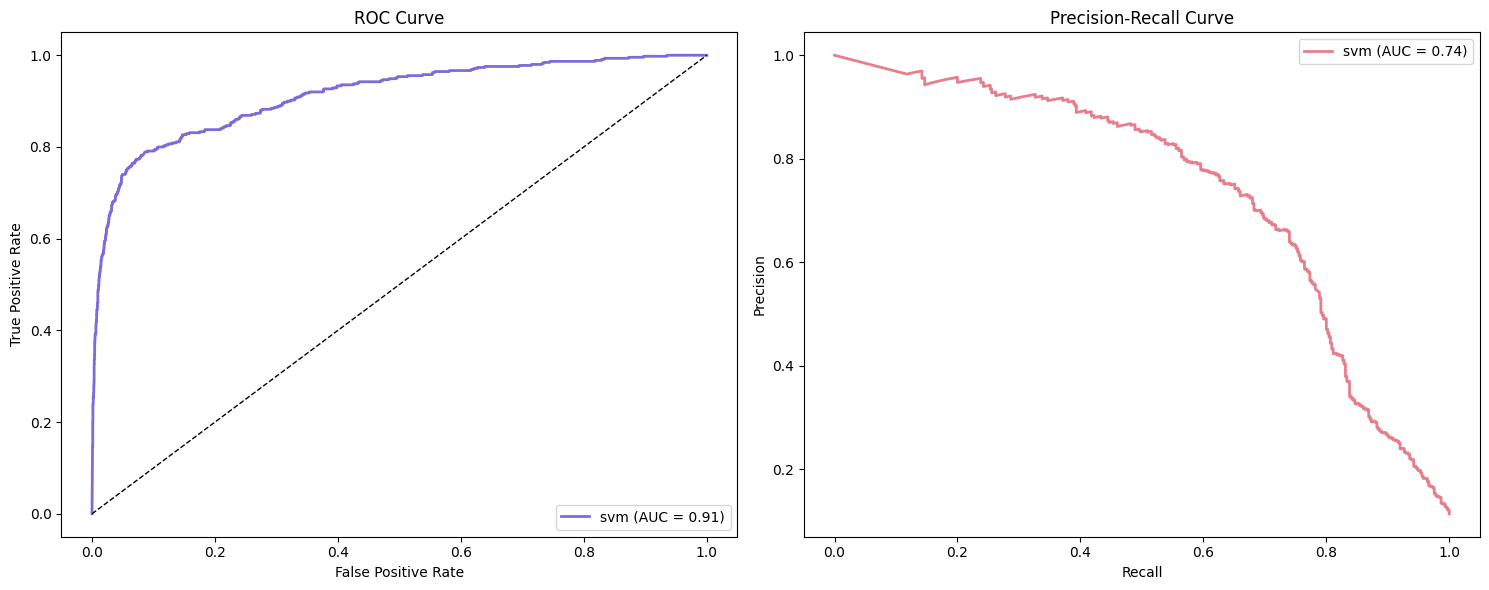

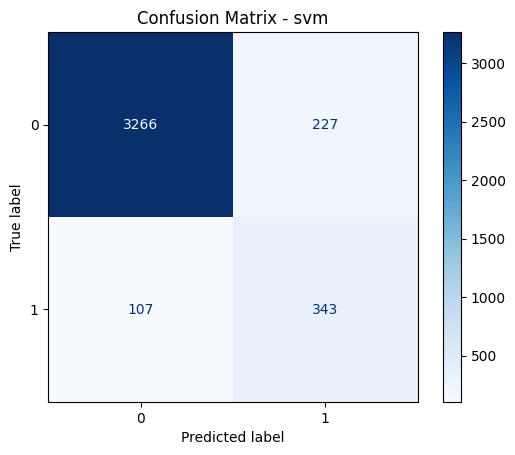


Результаты базовых моделей:
    model                                        best_params   roc_auc  \
2     xgb  {'model__learning_rate': 0.05, 'model__max_dep...  0.935580   
1      rf  {'model__class_weight': 'balanced', 'model__cr...  0.928935   
0  logreg  {'model__C': 0.5, 'model__class_weight': None,...  0.916893   
3     svm  {'model__C': 10, 'model__class_weight': 'balan...  0.912413   

     pr_auc        f1    recall  precision  
2  0.778687  0.734644  0.664444   0.821429  
1  0.751304  0.718938  0.662222   0.786280  
0  0.738131  0.624028  0.802222   0.510608  
3  0.737096  0.672549  0.762222   0.601754  


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



=== Этап 2: Создание и оценка ансамблей ===

Обучение ансамбля voting...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(



Обучение ансамбля stacking...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: User


=== Визуализация на кросс-валидации ===


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: User

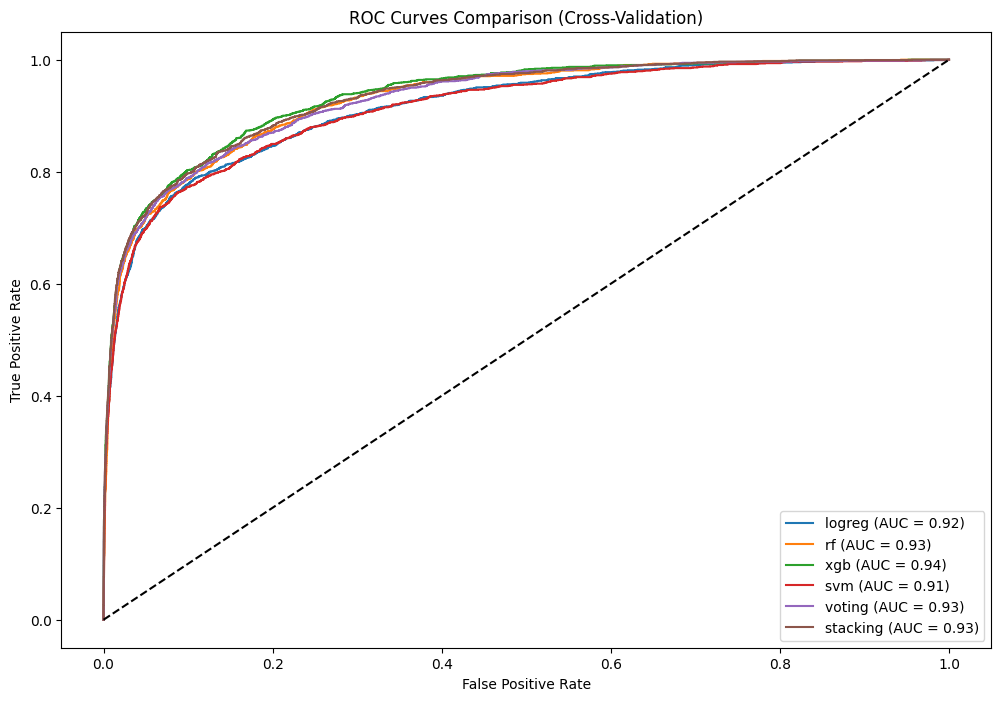


=== Сравнение всех моделей на тестовом наборе ===


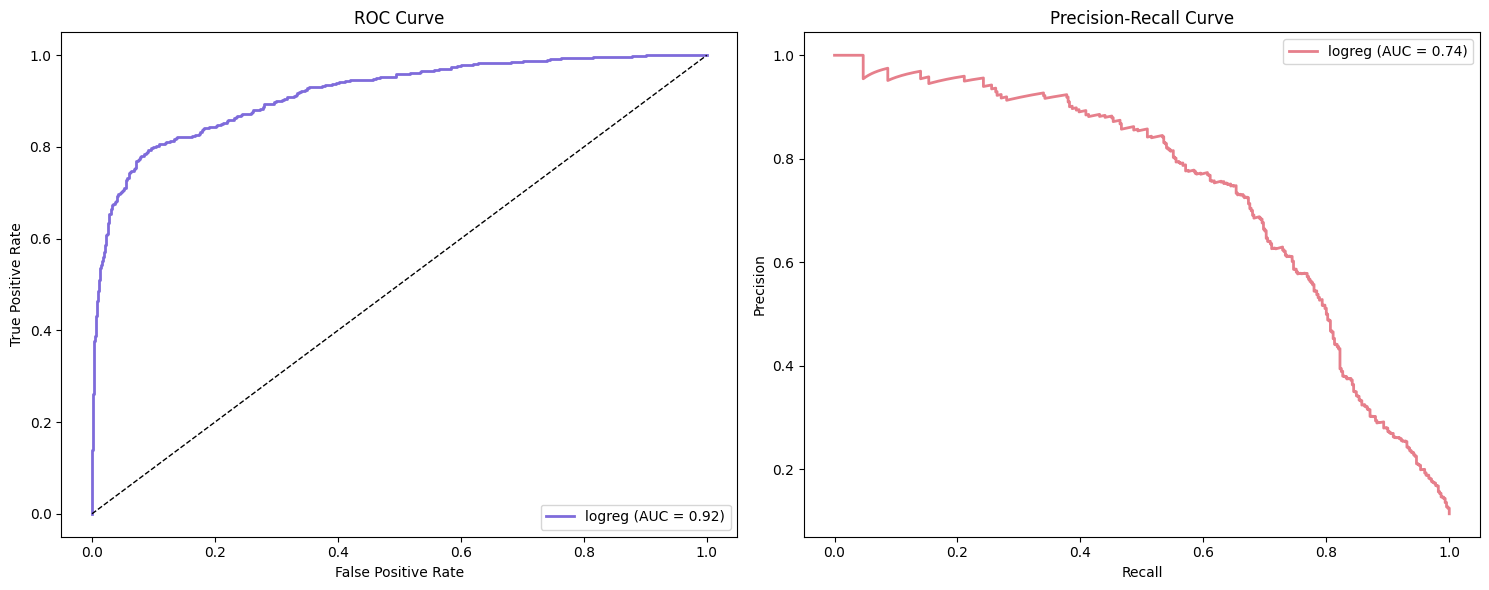

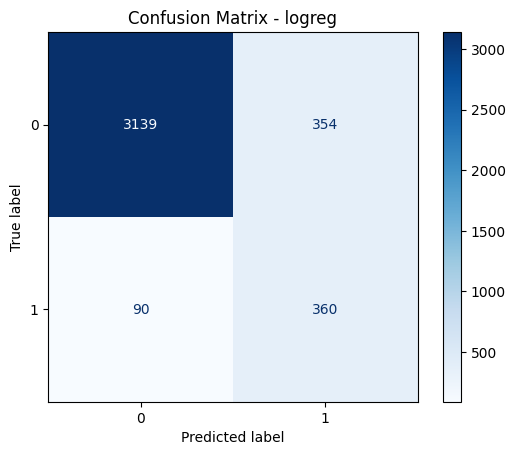

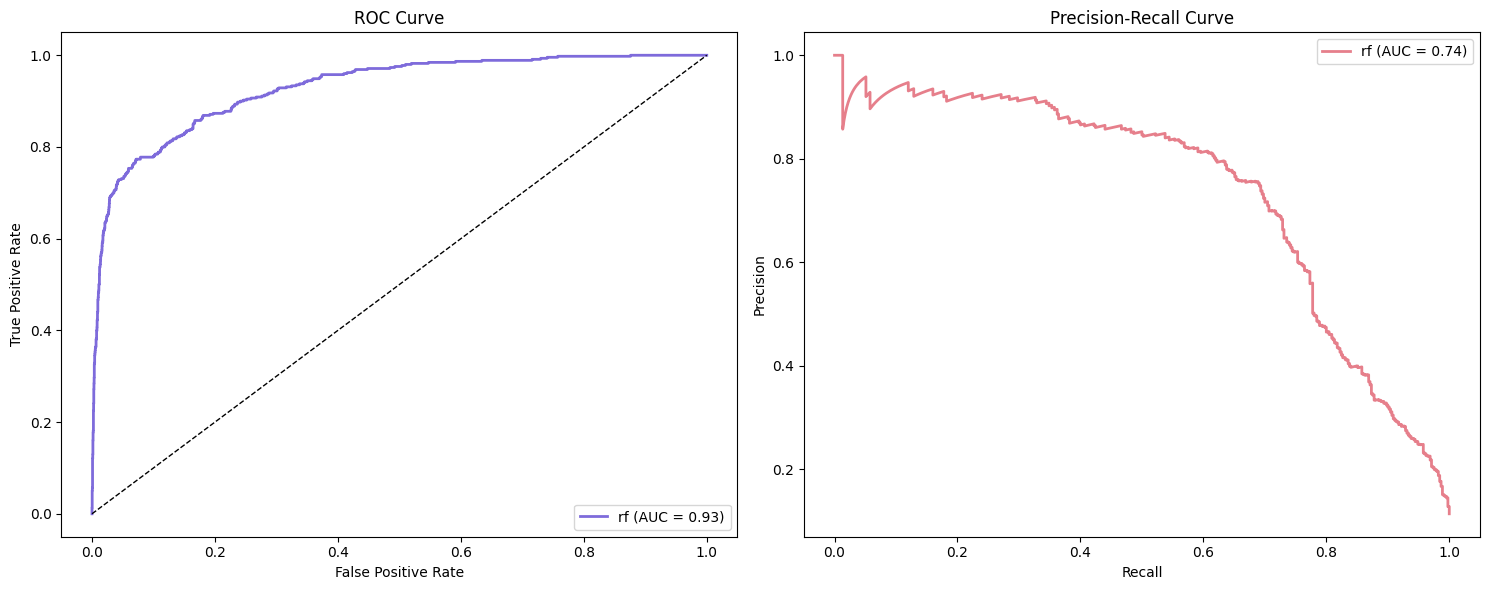

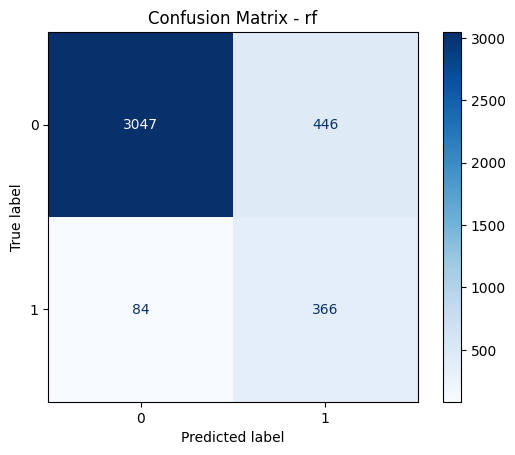

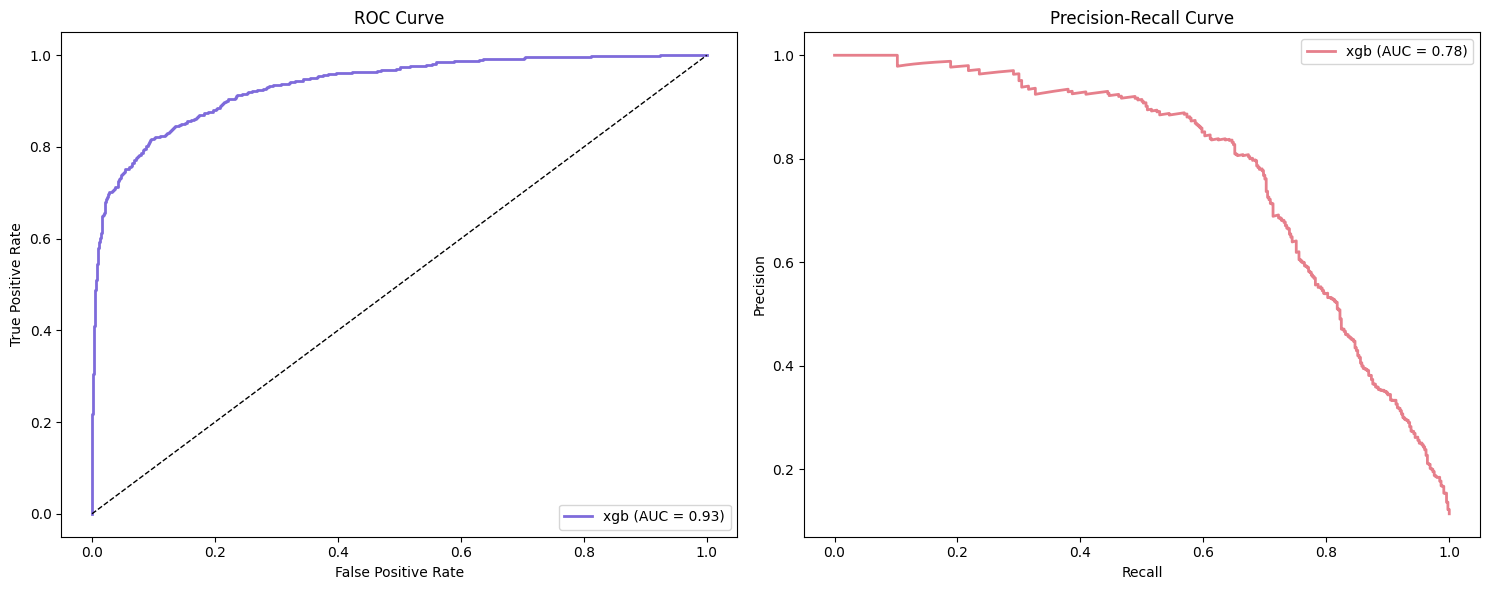

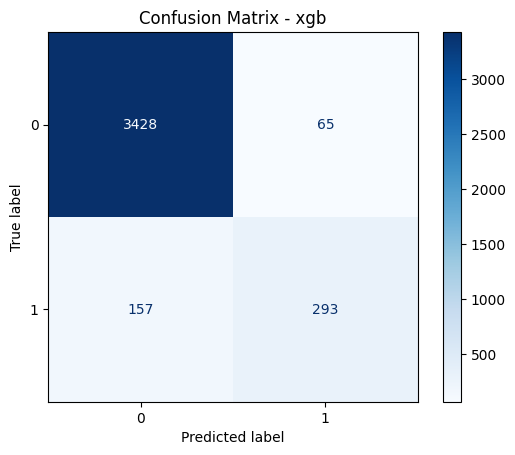

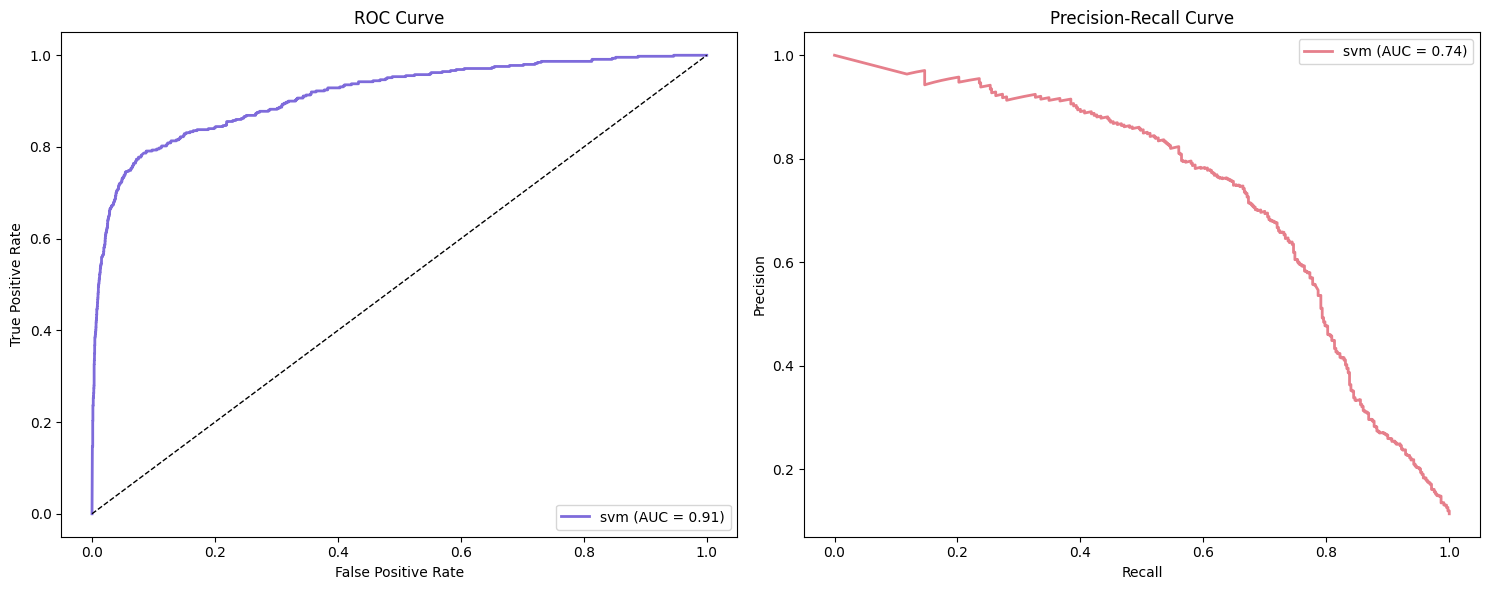

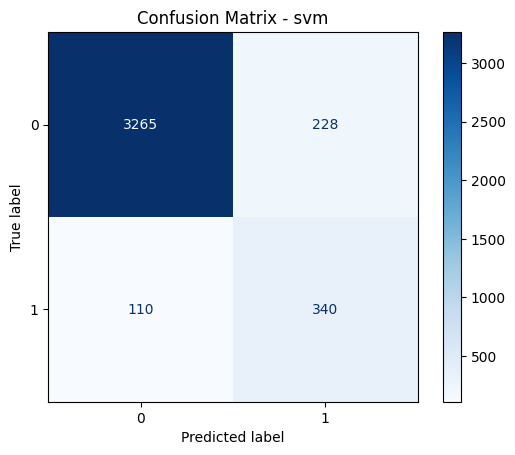

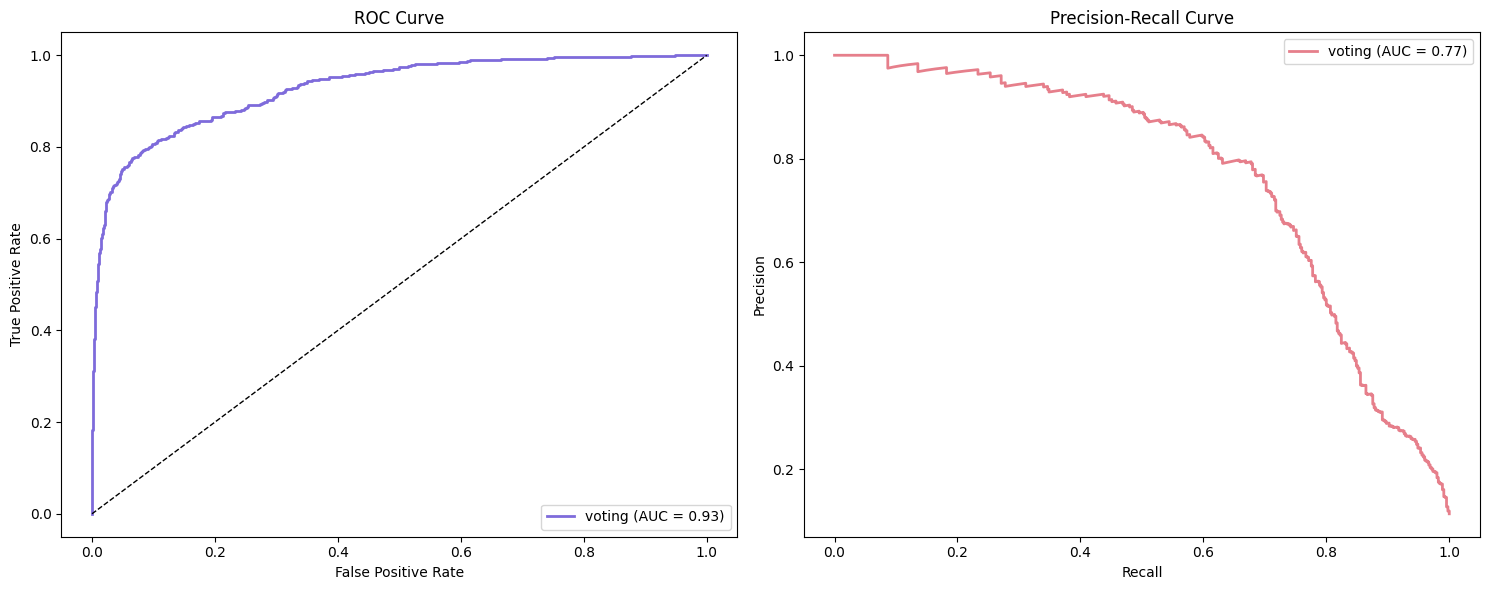

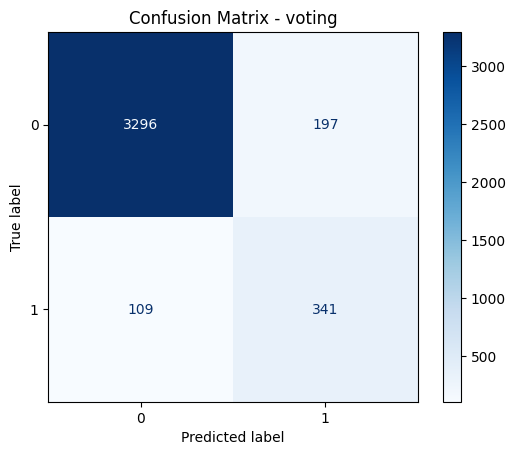

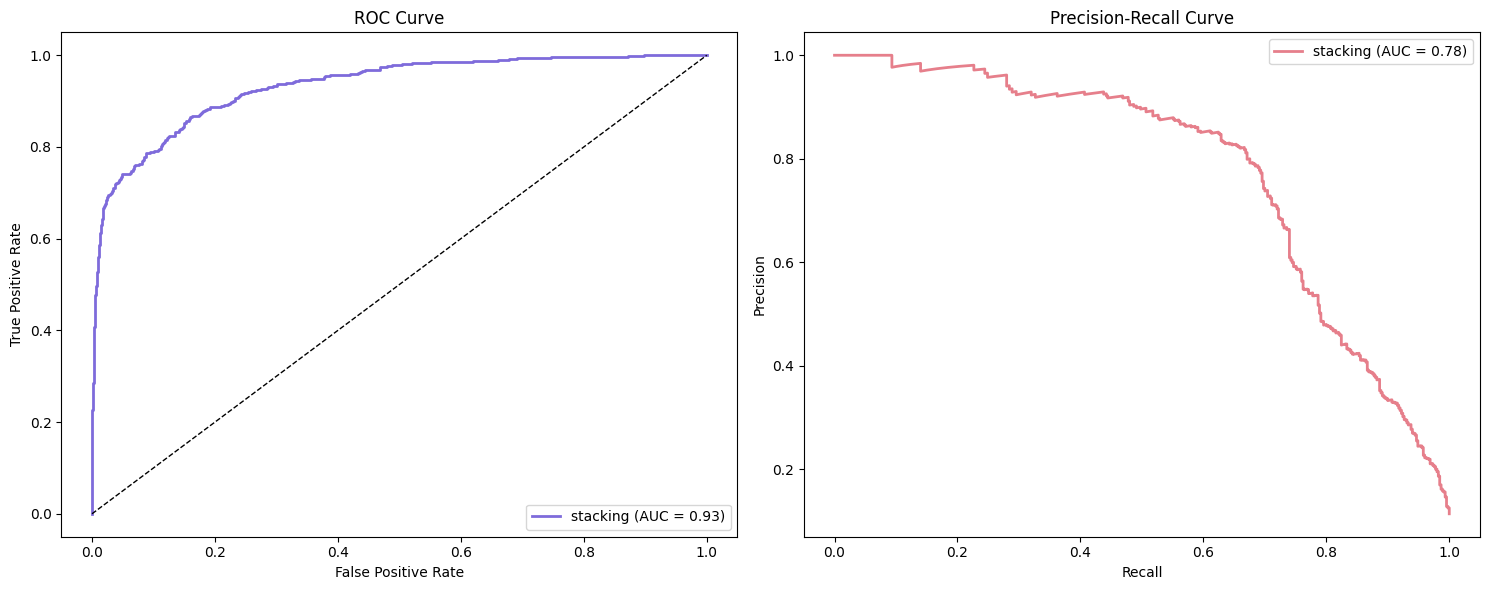

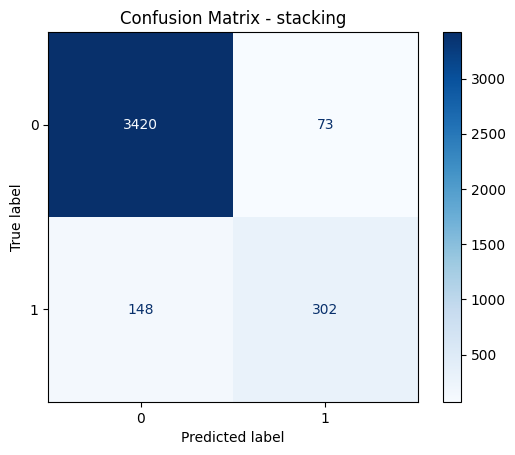


Финальные результаты:
      Model   ROC AUC    PR AUC        F1    Recall  Precision
2       xgb  0.934557  0.782997  0.725248  0.651111   0.818436
5  stacking  0.932791  0.775183  0.732121  0.671111   0.805333
4    voting  0.928375  0.771245  0.690283  0.757778   0.633829
1        rf  0.928231  0.739386  0.580032  0.813333   0.450739
0    logreg  0.916716  0.737285  0.618557  0.800000   0.504202
3       svm  0.912723  0.737221  0.667976  0.755556   0.598592


In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

def main():
    print("=== Этап 1: Обучение базовых моделей ===")
    base_results = evaluate_models(X_train_val, y_train_val, X_test, y_test)
    print("\nРезультаты базовых моделей:")
    print(base_results.sort_values('roc_auc', ascending=False))
    
    models = get_models_and_params()
    best_models = {}
    for name, (model, params) in models.items():
        pipeline = Pipeline([
            ('sampler', SMOTE()),
            ('model', model)
        ])
        grid = GridSearchCV(
            pipeline,
            param_grid=params,
            cv=skf,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train_val, y_train_val)
        best_models[name] = grid.best_estimator_
    
    print("\n=== Этап 2: Создание и оценка ансамблей ===")
    ensembles = create_ensembles(best_models)
    
    for name, ensemble in ensembles.items():
        print(f"\nОбучение ансамбля {name}...")
        ensemble.fit(X_train_val, y_train_val)
        best_models[name] = ensemble
    
    print("\n=== Визуализация на кросс-валидации ===")
    plot_cv_results(best_models, X_train_val, y_train_val, skf)
    
    print("\n=== Сравнение всех моделей на тестовом наборе ===")
    final_results = compare_models(best_models, X_test, y_test)
    print("\nФинальные результаты:")
    print(final_results.sort_values('ROC AUC', ascending=False))
    
    plt.show() 

if __name__ == "__main__":
    main()